##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
from datetime import date, datetime
import numpy as np
import random
from sklearn.ensemble import  GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import seaborn as sb
import matplotlib.pyplot as plt


filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
###...code...###
df = pd.read_parquet(filepath)
#test_df = test_df.dropna(axis = 1, how = 'all')  # remove all columns with all NA values
#df = test_df.drop('clntnum', axis = 1) # remove the clntnum column coz not useful for predictions
df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0)
col_names = list(df.columns)

### **Data cleaning/Feature Extraction**

__________

## Helper functions

In [4]:
def get_data_values(df, col_name): # Method to get unique data values from columns
    return(set(df[col_name].to_list()))

def get_unique_data_col(df, col_names):
    # Method here is to create a dictionary where each key is a column name and the values are the unique values for each column
    dct = {}
    
    for col in col_names:
        values = get_data_values(df, col)
        dct[col] = values
    return(dct)

def calculate_age(dob): # input is a string, calculates age of person based on date-of-birth
    date_format = '%Y-%m-%d'
    dob_formatted = datetime.strptime(dob, date_format)
    today = date.today()
    
    return today.year - dob_formatted.year - ((today.month, today.day) < (dob_formatted.month, dob_formatted.day))

def age_grouping(age):
    if age < 18:
         return('minor')
    elif age < 35:
        return('adult')
    elif age < 65:
        return('middle-aged')
    elif age >= 65:
        return('elderly')
    else:
        return(np.nan)

def impute_random(df, col_name, idx_lst):
    new_df = df.copy(deep = True)
    new_df = new_df.drop(idx_lst, axis = 0)

    lst = list(new_df[col_name])
    return(random.choice(lst))

def impute_missing_value(df, col_name):
    new_df = df.copy(deep = True)
    nan_idx_lst = list(new_df[new_df[col_name].isna()].index)
    new_df[col_name] = new_df[col_name].fillna(impute_random(new_df, col_name, nan_idx_lst))
    return(new_df)

def add_age_group(df): 
    new_df = df.copy(deep = True)
    
    # Find out ages of clients
    new_df['clt_age'] = new_df['cltdob_fix'].apply(lambda x : calculate_age(x) if x != 'None' else np.nan)
#    return(new_df)
    # There are 22 'None' values in the cltdob_fix column
    new_df['clt_age_grp'] = new_df['clt_age'].apply(lambda x: age_grouping(x))

    # Impute none values by randomly choosing from other entries
    # nan_idx_lst = list(new_df[new_df['clt_age_grp'].isna()].index)
    # new_df['clt_age_grp'] = new_df['clt_age_grp'].fillna(impute_random(new_df, 'clt_age_grp', nan_idx_lst))
    # for idx in nan_idx_lst:
    #     choice = impute_random(df, col_name, nan_idx_lst)
        
    # new_df["clt_age_grp"].fillna(lambda x: random.choice(new_df[new_df['clt_age_grp'] != np.nan]["clt_age_grp"]), inplace =True)
    new_df = impute_missing_value(new_df, 'clt_age_grp')
    
    ## No longer need cltodb_fix and clt_age columns -> May remove later
    return(new_df)

def calculate_rowwise_sum(df, columns, new_col_name):
    df[new_col_name] = df[columns].sum(axis=1)
    return df[new_col_name]

def get_income_per_hh_size(df):
    def encode_annual_income_est(x):
        if x is None:
            return 0
        elif x == "E.BELOW30K":
            return 1
        elif x == "D.30K-60K":
            return 2
        elif x == "C.60K-100K":
            return 3
        elif x == "B.100K-200K ":
            return 4
        elif x == "A.ABOVE200K":
            return 5
    def encode_hh_size_est(x):
        if x is None:
            return 0
        elif x == "1":
            return 1
        elif x == "2":
            return 1/2
        elif x == "3":
            return 1/3
        elif x == "4":
            return 1/4
        elif x == ">4":
            return 1/5
    def replace_zeros(x):
        if x==0:
            return np.nan
        else:
            return x

    temp1 = df['hh_size_est'].apply(lambda x: encode_hh_size_est(x))
    temp2 = df['annual_income_est'].apply(lambda x: encode_annual_income_est(x))
    result = temp1 * temp2
    return(result.apply(lambda x: replace_zeros(x)))

def no_bought_in_last_k_months(df,k):
    ref_df = df[['n_months_last_bought_839f8a',
       'n_months_last_bought_e22a6a', 'n_months_last_bought_d0adeb',
       'n_months_last_bought_c4bda5', 'n_months_last_bought_ltc',
       'n_months_last_bought_507c37', 'n_months_last_bought_gi',
       'n_months_last_bought_ltc_1280bf', 'n_months_last_bought_grp_6fc3e6',
       'n_months_last_bought_grp_de05ae', 'n_months_last_bought_inv_dcd836',
       'n_months_last_bought_grp_945b5a', 'n_months_last_bought_grp_6a5788',
       'n_months_last_bought_ltc_43b9d5', 'n_months_last_bought_grp_9cdedf',
       'n_months_last_bought_lh_d0adeb', 'n_months_last_bought_grp_1581d7',
       'n_months_last_bought_grp_22decf', 'n_months_last_bought_lh_507c37',
       'n_months_last_bought_lh_839f8a', 'n_months_last_bought_inv_e9f316',
       'n_months_last_bought_grp_caa6ff', 'n_months_last_bought_grp_fd3bfb',
       'n_months_last_bought_lh_e22a6a', 'n_months_last_bought_grp_70e1dd',
       'n_months_last_bought_grp_e04c3a', 'n_months_last_bought_grp_fe5fb8',
       'n_months_last_bought_grp_94baec', 'n_months_last_bought_grp_e91421',
       'n_months_last_bought_lh_f852af', 'n_months_last_bought_lh_947b15',
       'n_months_last_bought_32c74c']]
    for column in ref_df.columns:
        ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')

    below_threshold_count = (ref_df < k).sum(axis=1)
    return(below_threshold_count)

def no_lapsed_in_last_k_months(df,k):
    ref_df = df[['n_months_since_lapse_ltc_1280bf',
       'n_months_since_lapse_grp_6fc3e6', 'n_months_since_lapse_grp_de05ae',
       'n_months_since_lapse_inv_dcd836', 'n_months_since_lapse_grp_945b5a',
       'n_months_since_lapse_grp_6a5788', 'n_months_since_lapse_ltc_43b9d5',
       'n_months_since_lapse_grp_9cdedf', 'n_months_since_lapse_lh_d0adeb',
       'n_months_since_lapse_grp_1581d7', 'n_months_since_lapse_grp_22decf',
       'n_months_since_lapse_lh_507c37', 'n_months_since_lapse_lh_839f8a',
       'n_months_since_lapse_inv_e9f316', 'n_months_since_lapse_grp_caa6ff',
       'n_months_since_lapse_grp_fd3bfb', 'n_months_since_lapse_lh_e22a6a',
       'n_months_since_lapse_grp_70e1dd', 'n_months_since_lapse_grp_e04c3a',
       'n_months_since_lapse_grp_fe5fb8', 'n_months_since_lapse_grp_94baec',
       'n_months_since_lapse_grp_e91421', 'n_months_since_lapse_lh_f852af',
       'n_months_since_lapse_lh_947b15', 'n_months_since_lapse_32c74c']]
    for column in ref_df.columns:
        ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')

    below_threshold_count = (ref_df < k).sum(axis=1)
    return(below_threshold_count)

def calculate_rowwise_sum(df, columns, new_col_name):
    ref_df = df[columns]
    for column in ref_df.columns:
        ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')

    df[new_col_name] = df[columns].sum(axis=1)
    return df[new_col_name]

## Feature extraction for different types for features

In [5]:
#Demographic and SES Information

#Processing clttype and stat_flag, hh_size_est and annual_income_est
clttype_dummy_df = pd.get_dummies(df['clttype'], prefix='clttype', dummy_na=True)
test_df = pd.concat([df['f_purchase_lh'], clttype_dummy_df], axis=1)
stat_flag_dummy_df = pd.get_dummies(df['stat_flag'], prefix='stat_flag', dummy_na=True)
hh_size_est_dummy_df = pd.get_dummies(df['hh_size_est'], prefix='hh_size_est',dummy_na=True)
annual_income_est_dummy_df = pd.get_dummies(df['annual_income_est'], prefix='annual_income_est',dummy_na=True)

#Getting Days since first contact and Age
df['min_occ_date'].value_counts(dropna=False)
df['min_occ_date'] = pd.to_datetime(df['min_occ_date'],errors='coerce')
current_date = datetime.now()
df['days_since_first_contact'] = (current_date - df['min_occ_date']).dt.days
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'],errors='coerce')
df['age'] = (current_date - df['cltdob_fix']).dt.days/365.25

#Getting income per hh size
df['income_per_hh_size'] = get_income_per_hh_size(df)

df['income_per_hh_size'] = df['income_per_hh_size'].fillna(df['income_per_hh_size'].median()) 

demo_ses_df = pd.concat([df[['income_per_hh_size','is_sg_pr','is_housewife_retiree','is_class_1_2','days_since_first_contact','age']],clttype_dummy_df,stat_flag_dummy_df,hh_size_est_dummy_df,annual_income_est_dummy_df ],axis=1)



In [6]:
#Policy and Claim History +
#Client Risk and States Indicators

#Policy and Claim History
policy_and_claim_history_cols = ['recency_cancel','tot_inforce_pols','flg_latest_being_cancel',
                                 'flg_latest_being_lapse']

#Client Risk and States Indicators
risk_and_state_cols = ['flg_substandard','flg_is_borderline_standard','flg_is_revised_term','flg_gi_claim'
                       ,'flg_is_proposal','flg_is_returned_mail','flg_is_rental_flat']

filtered_columns_1 = df.loc[:, df.columns.str.startswith("flg_gi_claim")]


df['recency_cancel'] = df['recency_cancel'].fillna(0)
df['tot_cancel_pols'] = df['tot_cancel_pols'].fillna(0)
df['f_ever_declined_la'] = df['f_ever_declined_la'].fillna(0)
df['flg_latest_being_lapse'].value_counts(dropna=False)
df['no_gi_claims']  = calculate_rowwise_sum(df,filtered_columns_1.columns,'no_gi_claims')

policy_and_claim_history_df = pd.concat([df[policy_and_claim_history_cols],df['no_gi_claims']],axis=1)
risk_and_state_df = df[risk_and_state_cols]


C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')


In [7]:
#Anonymized Insurance Product Metrics

prefix_to_match_1 = 'ape_'
prefix_to_match_2 = 'f_ever_bought_'
prefix_to_match_3 = 'n_months_last_bought'
prefix_to_match_4 = 'lapse_ape'
prefix_to_match_5 = 'n_months_since_lapse'
prefix_to_match_6 = 'prempaid'
prefix_to_match_7 = 'sumin'
prefix_to_match_8 = 'f_hold'

filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)]
filtered_columns_2 = df.loc[:, df.columns.str.startswith(prefix_to_match_2)]
filtered_columns_3 = df.loc[:, df.columns.str.startswith(prefix_to_match_3)]
filtered_columns_4 = df.loc[:, df.columns.str.startswith(prefix_to_match_4)].fillna(0)
filtered_columns_5 = df.loc[:, df.columns.str.startswith(prefix_to_match_5)]
filtered_columns_6 = df.loc[:, df.columns.str.startswith(prefix_to_match_6)]
filtered_columns_7 = df.loc[:, df.columns.str.startswith(prefix_to_match_7)]
filtered_columns_8 = df.loc[:, df.columns.str.startswith(prefix_to_match_8)]
df['total_ape'] = calculate_rowwise_sum(df,filtered_columns_1.columns, 'total_ape')
df['total_prempaid'] = calculate_rowwise_sum(df,filtered_columns_6.columns, 'total_prempaid')
df['total_sumin'] = calculate_rowwise_sum(df,filtered_columns_7.columns, 'total_sumin')
df['total_hold'] = calculate_rowwise_sum(df,filtered_columns_8.columns, 'total_hold')
df['total_bought'] = calculate_rowwise_sum(df,filtered_columns_2.columns, 'total_bought')

anonymized_insurance_product_metrics_df = pd.concat([filtered_columns_1,filtered_columns_2, filtered_columns_3,filtered_columns_4,filtered_columns_5,df['total_ape'],
                                                     df['total_prempaid'],df['total_sumin'],df['total_hold'],df['total_bought']],axis=1)

C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [8]:
#No and Amt of Claims
prefix_to_match_1 = 'flg_hlthclaim_'

filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)].fillna(0)

df['no_health_claims'] = calculate_rowwise_sum(df,df.loc[:, df.columns.str.startswith(prefix_to_match_1)].columns,'no_health_claims')

claims_df = pd.concat([filtered_columns_1,filtered_columns_2,filtered_columns_3,filtered_columns_4,filtered_columns_5,filtered_columns_6,
                      df['no_health_claims'] ],axis=1)

C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')


In [9]:
#Client Communication Preferences and activity on Affinity Connect plus some other information

#Communication Preferences
comm_preferences_cols = ['is_valid_dm','is_valid_email']
comm_preferences_df = df[comm_preferences_cols]

#Affinity Connect
prefix_to_match_1 = 'flg_affconnect_'
affinity_connect_cols = ['n_months_since_visit_affcon']
df['n_months_since_visit_affcon'] = df['n_months_since_visit_affcon'].fillna(0)
filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)].fillna(0)

affinity_connect_df = pd.concat([df[affinity_connect_cols],filtered_columns_1],axis=1)

sectors_cols = ['f_elx', 'f_mindef_mha', 'f_retail']

sectors_df = df[sectors_cols] 

In [10]:
#All dfs put together

data = pd.concat([anonymized_insurance_product_metrics_df,claims_df,
                  comm_preferences_df,affinity_connect_df,sectors_df,policy_and_claim_history_df ,
                  risk_and_state_df ,demo_ses_df,sectors_df,df['f_purchase_lh']],axis=1)

data = data.loc[:, ~data.columns.duplicated()]

In [11]:
###Indicators for ability to cope with payments
data['no_lapsed_in_last_6_months'] = no_bought_in_last_k_months(data,6)
data['total_amt_lapsed'] = calculate_rowwise_sum(data,data.loc[:, data.columns.str.startswith('lapse_ape')].columns,'total_amt_lapsed')
coping_ability_indicators = ['flg_substandard','flg_is_borderline_standard','flg_latest_being_cancel','flg_latest_being_lapse','no_lapsed_in_last_6_months','total_amt_lapsed']


C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')


In [12]:
###Indicators for recency/activeness in buying products
data['no_bought_in_past_3_years'] = no_bought_in_last_k_months(data,3*12)
recency_indicators = ['recency_cancel','n_months_last_bought_products','no_bought_in_past_3_years']

C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')


In [13]:
###Indicators for wealth
wealth_indicators = ['hh_size_est_0', 'hh_size_est_1', 'hh_size_est_2', 'hh_size_est_3', 'hh_size_est_4', 'hh_size_est_>4', 'annual_income_est_A.ABOVE200K', 'annual_income_est_B.100K-200K', 'annual_income_est_C.60K-100K', 'annual_income_est_D.30K-60K', 'annual_income_est_E.BELOW30K','flg_is_rental_flat', 'income_per_hh_size']


In [14]:
###Indicators for communication 
comm_indicators = ['flg_is_returned_mail', 'is_valid_dm', 'is_valid_email','flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever','flg_affconnect_lapse_ever','n_months_since_visit_affcon']


In [15]:
### Indicators for healh/other health risks and statuses
health_and_other_status_indicators = ['is_class_1_2','is_housewife_retiree','is_sg_pr','f_elx','f_retail','f_mindef_mha']

In [16]:
### Indicators for commitment
commitment_indicators = ['total_bought','total_hold','tot_inforce_pols','no_health_claims','no_gi_claims',
                         'total_ape','total_prempaid','total_sumin','stat_flag_ACTIVE'	,'stat_flag_LAPSED','flg_is_proposal']


In [17]:
#Other Indicators
other_indicators = ['age','clttype_C', 'clttype_G', 'clttype_P']

In [18]:
data = data[coping_ability_indicators+recency_indicators+wealth_indicators+comm_indicators+health_and_other_status_indicators+commitment_indicators+other_indicators+['f_purchase_lh']]

In [19]:
def process_data(test_df):
    if 'f_purchase_lh' not in test_df:
        test_df['f_purchase_lh'] = 0
    test_df = test_df.dropna(axis = 1, how = 'all')  # remove all columns with all NA values
    df = test_df.drop('clntnum', axis = 1) # remove the clntnum column coz not useful for predictions
    df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0)
    clttype_dummy_df = pd.get_dummies(df['clttype'], prefix='clttype', dummy_na=True)
    test_df = pd.concat([df['f_purchase_lh'], clttype_dummy_df], axis=1)
    stat_flag_dummy_df = pd.get_dummies(df['stat_flag'], prefix='stat_flag', dummy_na=True)
    hh_size_est_dummy_df = pd.get_dummies(df['hh_size_est'], prefix='hh_size_est',dummy_na=True)
    annual_income_est_dummy_df = pd.get_dummies(df['annual_income_est'], prefix='annual_income_est',dummy_na=True)
    
    #Getting Days since first contact and Age
    df['min_occ_date'].value_counts(dropna=False)
    df['min_occ_date'] = pd.to_datetime(df['min_occ_date'],errors='coerce')
    current_date = datetime.now()
    df['days_since_first_contact'] = (current_date - df['min_occ_date']).dt.days
    df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'],errors='coerce')
    df['age'] = (current_date - df['cltdob_fix']).dt.days/365.25
    
    #Getting income per hh size
    df['income_per_hh_size'] = get_income_per_hh_size(df)
    
    df['income_per_hh_size'] = df['income_per_hh_size'].fillna(df['income_per_hh_size'].median()) 
    
    demo_ses_df = pd.concat([df[['income_per_hh_size','is_sg_pr','is_housewife_retiree','is_class_1_2','days_since_first_contact','age']],clttype_dummy_df,stat_flag_dummy_df,hh_size_est_dummy_df,annual_income_est_dummy_df ],axis=1)
    policy_and_claim_history_cols = ['recency_cancel','tot_inforce_pols','flg_latest_being_cancel',
                                     'flg_latest_being_lapse']
    
    #Client Risk and States Indicators
    risk_and_state_cols = ['flg_substandard','flg_is_borderline_standard','flg_is_revised_term','flg_gi_claim'
                           ,'flg_is_proposal','flg_is_returned_mail','flg_is_rental_flat']
    
    filtered_columns_1 = df.loc[:, df.columns.str.startswith("flg_gi_claim")]
    
    
    df['recency_cancel'] = df['recency_cancel'].fillna(0)
    df['tot_cancel_pols'] = df['tot_cancel_pols'].fillna(0)
    df['f_ever_declined_la'] = df['f_ever_declined_la'].fillna(0)
    df['flg_latest_being_lapse'].value_counts(dropna=False)
    df['no_gi_claims']  = calculate_rowwise_sum(df,filtered_columns_1.columns,'no_gi_claims')
    
    policy_and_claim_history_df = pd.concat([df[policy_and_claim_history_cols],df['no_gi_claims']],axis=1)
    risk_and_state_df = df[risk_and_state_cols]
    prefix_to_match_1 = 'ape_'
    prefix_to_match_2 = 'f_ever_bought_'
    prefix_to_match_3 = 'n_months_last_bought'
    prefix_to_match_4 = 'lapse_ape'
    prefix_to_match_5 = 'n_months_since_lapse'
    prefix_to_match_6 = 'prempaid'
    prefix_to_match_7 = 'sumin'
    prefix_to_match_8 = 'f_hold'
    
    filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)]
    filtered_columns_2 = df.loc[:, df.columns.str.startswith(prefix_to_match_2)]
    filtered_columns_3 = df.loc[:, df.columns.str.startswith(prefix_to_match_3)]
    filtered_columns_4 = df.loc[:, df.columns.str.startswith(prefix_to_match_4)].fillna(0)
    filtered_columns_5 = df.loc[:, df.columns.str.startswith(prefix_to_match_5)]
    filtered_columns_6 = df.loc[:, df.columns.str.startswith(prefix_to_match_6)]
    filtered_columns_7 = df.loc[:, df.columns.str.startswith(prefix_to_match_7)]
    filtered_columns_8 = df.loc[:, df.columns.str.startswith(prefix_to_match_8)]
    df['total_ape'] = calculate_rowwise_sum(df,filtered_columns_1.columns, 'total_ape')
    df['total_prempaid'] = calculate_rowwise_sum(df,filtered_columns_6.columns, 'total_prempaid')
    df['total_sumin'] = calculate_rowwise_sum(df,filtered_columns_7.columns, 'total_sumin')
    df['total_hold'] = calculate_rowwise_sum(df,filtered_columns_8.columns, 'total_hold')
    df['total_bought'] = calculate_rowwise_sum(df,filtered_columns_2.columns, 'total_bought')
    
    anonymized_insurance_product_metrics_df = pd.concat([filtered_columns_1,filtered_columns_2, filtered_columns_3,filtered_columns_4,filtered_columns_5,df['total_ape'],
                                                         df['total_prempaid'],df['total_sumin'],df['total_hold'],df['total_bought']],axis=1)
    
    prefix_to_match_1 = 'flg_hlthclaim_'
    
    filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)].fillna(0)
    
    df['no_health_claims'] = calculate_rowwise_sum(df,df.loc[:, df.columns.str.startswith(prefix_to_match_1)].columns,'no_health_claims')
    
    claims_df = pd.concat([filtered_columns_1,filtered_columns_2,filtered_columns_3,filtered_columns_4,filtered_columns_5,filtered_columns_6,
                          df['no_health_claims'] ],axis=1)
    
    comm_preferences_cols = ['is_valid_dm','is_valid_email']
    comm_preferences_df = df[comm_preferences_cols]
    
    #Affinity Connect
    prefix_to_match_1 = 'flg_affconnect_'
    affinity_connect_cols = ['n_months_since_visit_affcon']
    df['n_months_since_visit_affcon'] = df['n_months_since_visit_affcon'].fillna(0)
    filtered_columns_1 = df.loc[:, df.columns.str.startswith(prefix_to_match_1)].fillna(0)
    
    affinity_connect_df = pd.concat([df[affinity_connect_cols],filtered_columns_1],axis=1)
    
    sectors_cols = ['f_elx', 'f_mindef_mha', 'f_retail']
    
    sectors_df = df[sectors_cols] 
    
    
    data = pd.concat([anonymized_insurance_product_metrics_df,claims_df,
                      comm_preferences_df,affinity_connect_df,sectors_df,policy_and_claim_history_df ,
                      risk_and_state_df ,demo_ses_df,sectors_df,df['f_purchase_lh']],axis=1)
    
    data = data.loc[:, ~data.columns.duplicated()]
    
    data['no_lapsed_in_last_6_months'] = no_bought_in_last_k_months(data,6)
    data['total_amt_lapsed'] = calculate_rowwise_sum(data,data.loc[:, data.columns.str.startswith('lapse_ape')].columns,'total_amt_lapsed')
    coping_ability_indicators = ['flg_substandard','flg_is_borderline_standard','flg_latest_being_cancel','flg_latest_being_lapse','no_lapsed_in_last_6_months','total_amt_lapsed']
    
    data['no_bought_in_past_3_years'] = no_bought_in_last_k_months(data,3*12)
    recency_indicators = ['recency_cancel','n_months_last_bought_products','no_bought_in_past_3_years']
    
    wealth_indicators = ['hh_size_est_0', 'hh_size_est_1', 'hh_size_est_2', 'hh_size_est_3', 'hh_size_est_4', 'hh_size_est_>4', 'annual_income_est_A.ABOVE200K', 'annual_income_est_B.100K-200K', 'annual_income_est_C.60K-100K', 'annual_income_est_D.30K-60K', 'annual_income_est_E.BELOW30K','flg_is_rental_flat', 'income_per_hh_size']
    
    comm_indicators = ['flg_is_returned_mail', 'is_valid_dm', 'is_valid_email','flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever','flg_affconnect_lapse_ever','n_months_since_visit_affcon']
    
    health_and_other_status_indicators = ['is_class_1_2','is_housewife_retiree','is_sg_pr','f_elx','f_retail','f_mindef_mha']
    
    commitment_indicators = ['total_bought','total_hold','tot_inforce_pols','no_health_claims','no_gi_claims',
                             'total_ape','total_prempaid','total_sumin','stat_flag_ACTIVE'	,'stat_flag_LAPSED','flg_is_proposal']
    
    other_indicators = ['age','clttype_C', 'clttype_G', 'clttype_P']
    
    data = data[coping_ability_indicators+recency_indicators+wealth_indicators+comm_indicators+health_and_other_status_indicators+commitment_indicators+other_indicators+['f_purchase_lh']]

    return(data)

### Model

In [20]:
rfc = RandomForestClassifier()
xgb = xgboost.XGBClassifier()
adaboost_classifier = AdaBoostClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)


train_df = pd.DataFrame(data)
train_df = train_df.astype({'total_amt_lapsed' : 'float64', 'total_ape' : 'float64', 'total_prempaid' : 'float64', 'total_sumin' : 'float64', 'no_gi_claims' : 'float64'})

X = train_df.loc[:, data.columns != 'f_purchase_lh']
y = train_df['f_purchase_lh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rows_with_missing_values = list(X_train[X_train.isnull().any(axis=1)].index)

X_train = X_train[~X_train.index.isin(rows_with_missing_values)]
y_train = y_train[~y_train.index.isin(rows_with_missing_values)]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [21]:
selector = RFE(xgb, n_features_to_select = 47, step = 1)
selector = selector.fit(X_train, y_train)
features_selected = selector.support_
selected_X_train = X_train.iloc[:, features_selected]
selected_X_test = X_test.iloc[:, features_selected]
selected_X_train = selected_X_train[~X_train.index.isin(rows_with_missing_values)]
y_train = y_train[~y_train.index.isin(rows_with_missing_values)]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(selected_X_train, y_train)
xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(selected_X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3448
         1.0       0.69      0.16      0.26       151

    accuracy                           0.96      3599
   macro avg       0.83      0.58      0.62      3599
weighted avg       0.95      0.96      0.95      3599



In [22]:
X_resampled.dtypes

flg_substandard                      float64
flg_is_borderline_standard           float64
flg_latest_being_cancel                int64
flg_latest_being_lapse                 int64
no_lapsed_in_last_6_months             int64
total_amt_lapsed                     float64
recency_cancel                       float64
n_months_last_bought_products          int64
no_bought_in_past_3_years              int64
hh_size_est_1                           bool
hh_size_est_2                           bool
hh_size_est_3                           bool
hh_size_est_4                           bool
hh_size_est_>4                          bool
annual_income_est_A.ABOVE200K           bool
annual_income_est_B.100K-200K           bool
annual_income_est_C.60K-100K            bool
annual_income_est_D.30K-60K             bool
annual_income_est_E.BELOW30K            bool
flg_is_rental_flat                   float64
income_per_hh_size                   float64
is_valid_dm                          float64
is_valid_e

In [23]:
def create_model(data):
    rfc = RandomForestClassifier()
    xgb = xgboost.XGBClassifier()
    adaboost_classifier = AdaBoostClassifier(random_state=42)
    gb_classifier = GradientBoostingClassifier(random_state=42)
    
    
    train_df = pd.DataFrame(data)
    
    X = train_df.loc[:, data.columns != 'f_purchase_lh']
    y = train_df['f_purchase_lh']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rows_with_missing_values = list(X_train[X_train.isnull().any(axis=1)].index)
    
    X_train = X_train[~X_train.index.isin(rows_with_missing_values)]
    y_train = y_train[~y_train.index.isin(rows_with_missing_values)]
    selector = RFE(xgb, n_features_to_select = 47, step = 1)
    selector = selector.fit(X_train, y_train)
    features_selected = selector.support_
    selected_X_train = X_train.iloc[:, features_selected]
    selected_X_test = X_test.iloc[:, features_selected]
    selected_X_train = selected_X_train[~X_train.index.isin(rows_with_missing_values)]
    y_train = y_train[~y_train.index.isin(rows_with_missing_values)]
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(selected_X_train, y_train)
    xgb.fit(X_resampled, y_resampled)
    return(xgb)


### **Feature selection**

In [24]:
# dct = {}
# for i in range(1, 50):
#     selector = RFE(xgb, n_features_to_select = i, step = 1)
#     selector = selector.fit(X_train, y_train)
#     features_selected = selector.support_
#     selected_X_train = X_train.iloc[:, features_selected]
#     selected_X_test = X_test.iloc[:, features_selected]
#     selected_X_train = selected_X_train[~X_train.index.isin(rows_with_missing_values)]
#     y_train = y_train[~y_train.index.isin(rows_with_missing_values)]
    
#     smote = SMOTE(random_state=42)
#     X_resampled, y_resampled = smote.fit_resample(selected_X_train, y_train)
#     xgb.fit(X_resampled, y_resampled)
#     y_pred = xgb.predict(selected_X_test)

#     dct[i] = classification_report(y_test, y_pred)

<Axes: xlabel='f_purchase_lh', ylabel='count'>

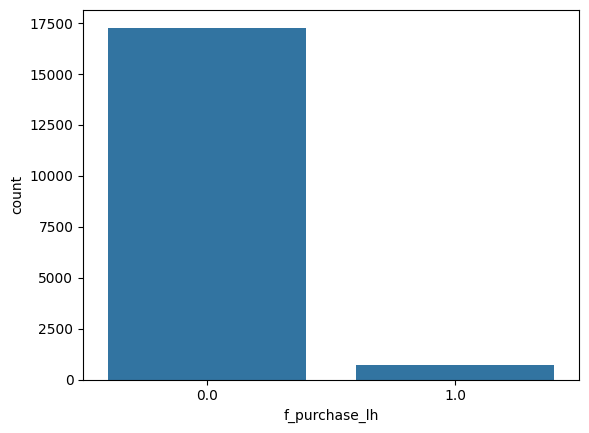

In [25]:
#visualising the data set
train_df.isnull().mean()
sb.countplot(x='f_purchase_lh',data=train_df)

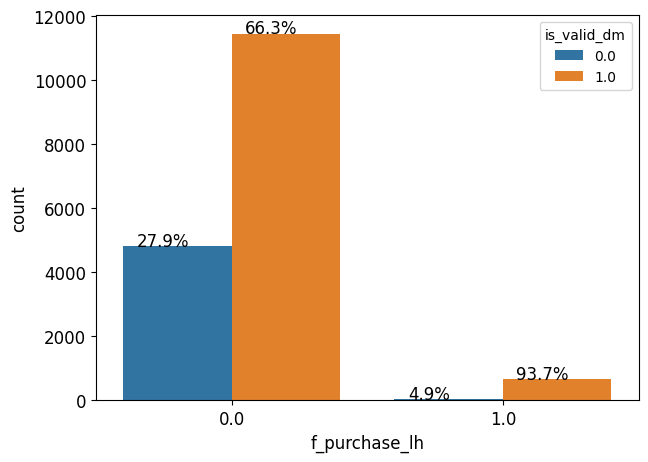

In [26]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

plt.figure(figsize=(7,5))
ax = sb.countplot(x='f_purchase_lh',data=train_df,hue='is_valid_dm')
plt.xticks(size=12)
plt.xlabel('f_purchase_lh',size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
with_hue(ax,train_df.f_purchase_lh,2,2)

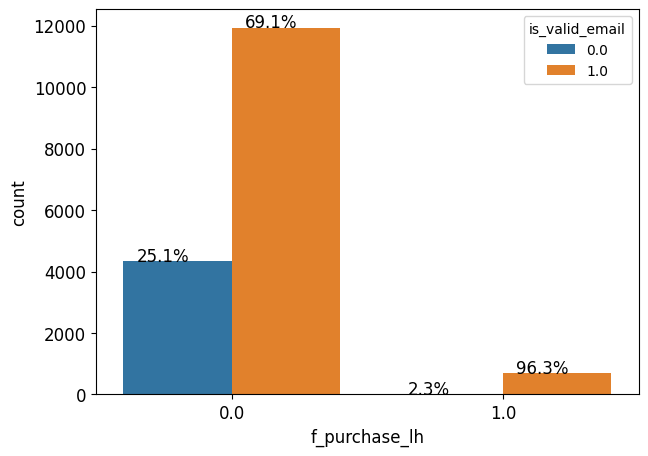

In [27]:
#f_purchase_lh vs is_valid_email
plt.figure(figsize=(7,5))
ax = sb.countplot(x='f_purchase_lh',data=train_df,hue='is_valid_email')
plt.xticks(size=12)
plt.xlabel('f_purchase_lh',size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
with_hue(ax,train_df.f_purchase_lh,2,2)

# is_valid_email also show similar results, and we use the same method for different variables in order to check whether they are significant

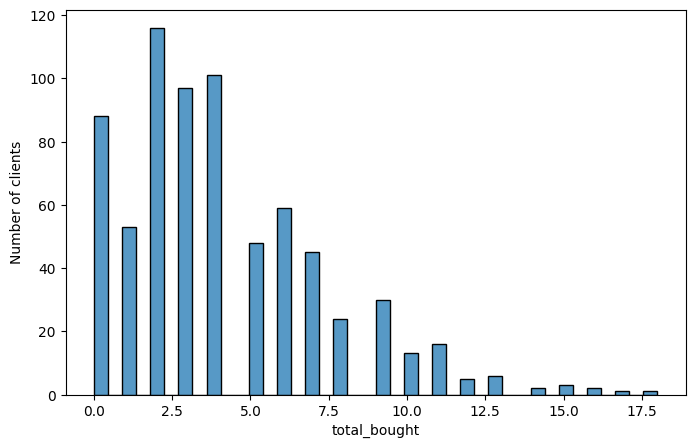

In [28]:
#total_bought vs f_purchase_lh
filtered_df = train_df[train_df['f_purchase_lh']==1]


plt.figure(figsize=[8,5])
sb.histplot(data=filtered_df,x="total_bought",bins=40).set(ylabel="Number of clients")
plt.show()

### Loading the model

In [29]:
filepath = "./data/catB_train.parquet" 
df = pd.read_parquet(filepath, engine = 'fastparquet')
data = process_data(df)
model = create_model(data)

C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [30]:
y_pred = model.predict(selected_X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3448
         1.0       0.69      0.16      0.26       151

    accuracy                           0.96      3599
   macro avg       0.83      0.58      0.62      3599
weighted avg       0.95      0.96      0.95      3599



## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [31]:
def testing_hidden_data(test_df):
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    test_data = process_data(test_df)
    test_data = test_data.astype({'total_amt_lapsed' : 'float64', 'total_ape' : 'float64', 'total_prempaid' : 'float64', 'total_sumin' : 'float64', 'no_gi_claims' : 'float64'})
    test_data = test_data.loc[:, test_data.columns != 'f_purchase_lh']
    selected_test_data = test_data.iloc[:, features_selected]
    rows_with_missing_values = list(selected_test_data[selected_test_data.isnull().any(axis=1)].index)
    
    selected_test_data = selected_test_data[~selected_test_data.index.isin(rows_with_missing_values)]
   # return(selected_test_data)
    result =  list(model.predict(selected_test_data))
    return result

##### Cell to check testing_hidden_data function

In [32]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[column] = pd.to_numeric(ref_df[column], errors='coerce')
C:\Users\hweih\AppData\Local\Temp\ipykernel_23036\2490242222.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!